In [31]:
import cv2
import matplotlib.pyplot as plt
from utils import read_image, ImageDomain, show_image_dist
import main as m

In [32]:
raw = cv2.imread('data/camera_raw.tif', cv2.IMREAD_UNCHANGED)
processed = cv2.imread('data/camera_normalized_logarithm.tif', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('data/raw_mask.tif', cv2.IMREAD_UNCHANGED)

conventional = cv2.imread('data/conventional_transmissionmap.tif', cv2.IMREAD_UNCHANGED)
conventional_processed = cv2.imread('data/conventional_processed.tif', cv2.IMREAD_UNCHANGED)


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


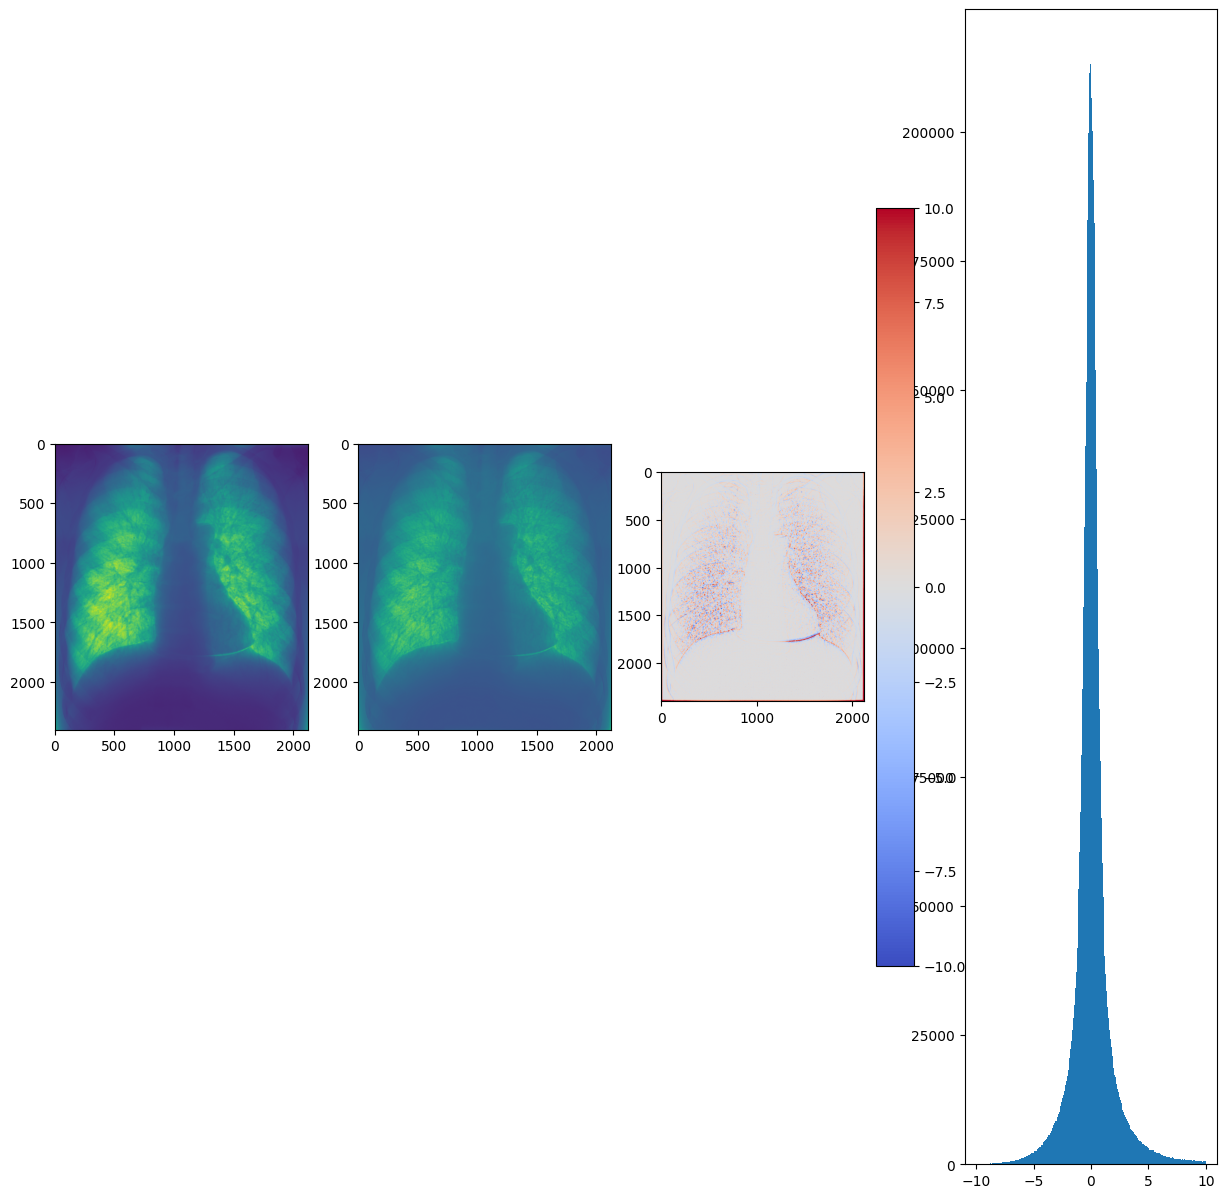

In [29]:
proc =  m.multiscale_processing(conventional, [3, 9, 27], [0.5, 0.5, 0.5])

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(conventional)
ax[1].imshow(proc)
diff = proc - conventional
a = ax[2].imshow(diff, cmap='coolwarm',vmin=-10, vmax=10)
vals = diff.ravel()
vals = vals[(vals > -10) & (vals < 10)]
ax[3].hist(vals, bins=256)

fig.colorbar(a)

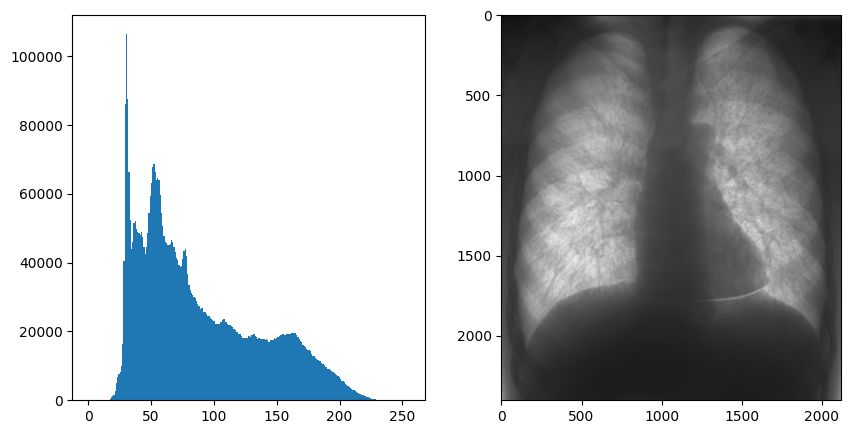

In [3]:
show_image_dist(conventional)

In [ ]:
import numpy as np

pipe = conventional / conventional.max()
pipe = 1 - pipe
pipe = apply_lut(pipe)
pipe = equalize_histogram(pipe, 8)


def unsharp_mask(image, kernel_size, factor):
    blur = cv2.boxFilter(np.array(image * 255, dtype=np.uint8), -1, (kernel_size, kernel_size))
    blur = blur / 255
    lowpass = image - blur

    return image + factor * lowpass


pipe = unsharp_mask(pipe, 3, 0.2)
pipe = unsharp_mask(pipe, 9, 0.1)


# factors = [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5]

# import math

# grid_size = math.sqrt(len(factors))
# grid_size = math.ceil(grid_size)

# fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
# axs = axes.flatten()

# for ax, factor in zip(axs, factors):
#     ax.imshow(pipe + factor * lowpass, cmap='gray')

# pipe = pipe + 0 * (lowpass)


pipe = np.clip(pipe, 0, 1)

plt.imshow(np.clip(pipe, 0, 1), cmap='gray')
# plt.hist(pipe.ravel(), bins=256)

In [ ]:
cv2.imwrite('data/pipe.tif', np.array(pipe * (2 ** 16 - 1), dtype=np.uint16))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(conventional.ravel(), bins=256)
axs[1].hist(conventional_processed.ravel(), bins=256)

<Figure size 640x480 with 0 Axes>

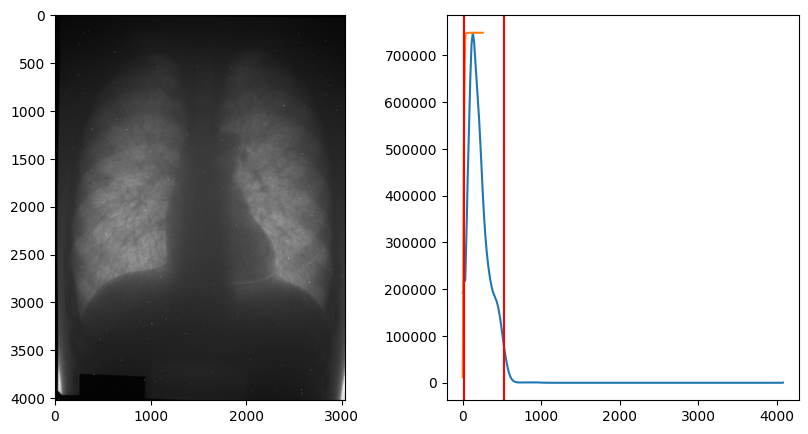

<Figure size 640x480 with 0 Axes>

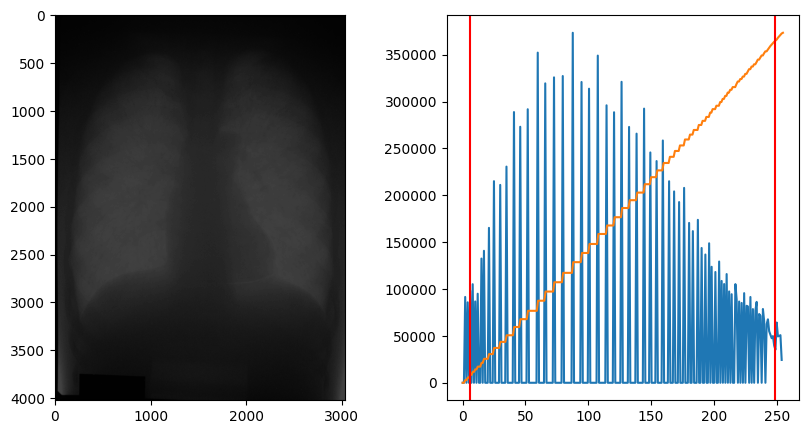

<Figure size 640x480 with 0 Axes>

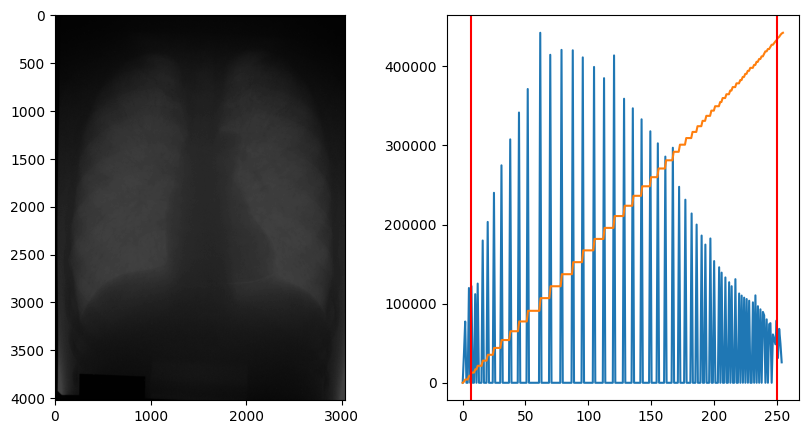

<Figure size 640x480 with 0 Axes>

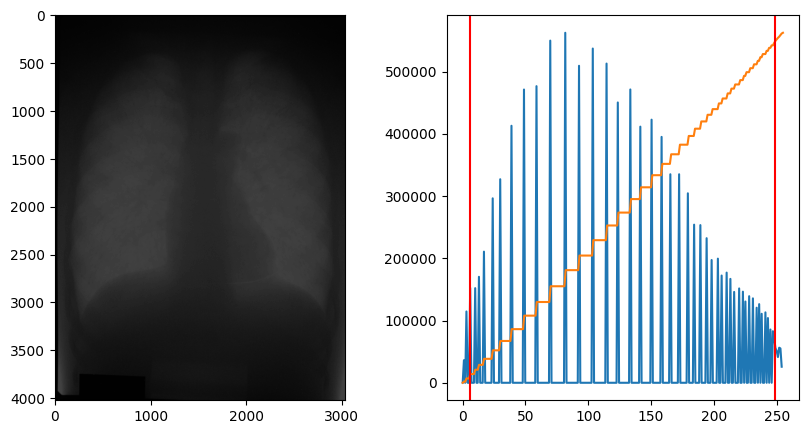

(Array(5.9765625, dtype=float32), Array(249.02344, dtype=float32))

In [3]:
import jax.scipy as jsp
import jax.numpy as jnp
import numpy as np
import cv2
import matplotlib.pyplot as plt

def read_img_data(path: str, imread_mode: int = cv2.IMREAD_UNCHANGED) -> jnp.array:
    img = cv2.imread(path, imread_mode)
    return img, jnp.array(img)


def show_img(data: jnp.array, vmin: int = 0, vmax: int = 1000, bins: int = 256, threshold: float = 0.02):
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    hist, bins = jnp.histogram(data.flatten(), bins=bins)
    axes[1].plot(bins[:-1], hist)
    cdf = hist.cumsum()
    axes[1].plot(cdf * hist.max() / cdf.max())

    low = bins[jnp.argmax(cdf > threshold * cdf.max())]
    high = bins[jnp.argmax(cdf > (1 - threshold) * cdf.max())]

    axes[1].axvline(low, color='r')
    axes[1].axvline(high, color='r')
    

    axes[0].imshow(data, cmap="gray", vmin=vmin, vmax=vmax)
    # axes[0].imshow(data, cmap="gray", vmin=vmin, vmax=vmax)

    plt.show()

    return low, high

def hist_equalize(data: jnp.array, threshold: float = 0.02):

    hist, bins = jnp.histogram(data.flatten(), bins=256)
    cdf = hist.cumsum()

    low = bins[jnp.argmax(cdf > threshold * cdf.max())]
    high = bins[jnp.argmax(cdf > (1 - threshold) * cdf.max())]

    maxv = data.max()
    minv = data.min()

    new = (high - low) * (data - minv) / (maxv - minv) + low

    return cv2.equalizeHist(np.array(new, dtype=np.uint8))

imgsrc, raw = read_img_data("data/camera_raw.tif", cv2.IMREAD_UNCHANGED)


show_img(imgsrc)
show_img(hist_equalize(imgsrc, threshold=0.01))
show_img(hist_equalize(imgsrc, threshold=0.05))
show_img(hist_equalize(imgsrc, threshold=0.1))
# show_img(raw, vmin=5000, vmax=20000)

In [ ]:
show_img(raw)
show_img(processed)

In [ ]:
def unsharp_mask(data: jnp.array, factor: float = 1.0, kernel_size: int = 3):
    kernel = jnp.ones((kernel_size, kernel_size)) / kernel_size ** 2
    blurred = jsp.signal.convolve(data, kernel, mode='same') 

    return data + factor * (data - blurred)


def to_cv2(data: jnp.array):
    return np.array(data, dtype=np.uint8)


def sigmoid_transfer(data: jnp.array, a: float = 25.0, b: float = 125):
    return 255 / (1 + jnp.exp(-(1 / a) * (data - b)))

def transfer(data: jnp.array, b: float = 1.0 / 8.0, c: float = 1.0):
    a = 255 / jnp.log(b * 255 + c)

    return a * jnp.log(b * data + c)
    


out = unsharp_mask(hist_equalize(imgsrc), factor=1.5, kernel_size=10)
show_img(imgsrc)
show_img(hist_equalize(imgsrc))
show_img(transfer(hist_equalize(imgsrc), b=0.25))


show_img(sigmoid_transfer(imgsrc, a=18.0))

In [ ]:
show_img(hist_equalize(imgsrc))

out = unsharp_mask(imgsrc, factor=0.5, kernel_size=3)
show_img(out)
out = unsharp_mask(out, factor=0.5, kernel_size=10)
show_img(out)
out = unsharp_mask(out, factor=0.5, kernel_size=50)
show_img(out)

In [ ]:

# show_img(out, vmin=0, vmax=634)
# show_img(jnp.log(raw))
show_img(raw)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def create_lookup_table(x, breakpoints, values):
    """Create a piecewise linear lookup table breakpoints: list of x coordinates for the breakpoints values: list of y coordinates for the breakpoints"""
    lut = np.zeros_like(x, dtype=float)
    breakpoints = np.array(breakpoints)
    values = np.array(values)

    # Handle values below first breakpoint
    lut[x <= breakpoints[0]] = values[0]

    # Handle values above last breakpoint
    lut[x >= breakpoints[-1]] = values[-1]

    # Handle intermediate segments
    for i in range(len(breakpoints) - 1):
        mask = (x > breakpoints[i]) & (x <= breakpoints[i + 1])
        x1, x2 = breakpoints[i], breakpoints[i + 1]
        y1, y2 = values[i], values[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        lut[mask] = y1 + slope * (x[mask] - x1)

    return lut


def adaptive_histogram_equalization(image, kernel_size=None):
    """
    Implement adaptive histogram equalization
    """
    if kernel_size is None:
        kernel_size = max(image.shape) // 8

    # Pad image
    pad_h = kernel_size // 2
    pad_w = kernel_size // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode="reflect")

    result = np.zeros_like(image, dtype=float)

    # Process each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract local region
            region = padded[i : i + kernel_size, j : j + kernel_size]
            # Get pixel value
            pixel = image[i, j]
            # Calculate local CDF
            hist, bins = np.histogram(region, bins=256, range=(0, 1))
            cdf = hist.cumsum() / hist.sum()
            # Map pixel value through local CDF
            idx = int(pixel * 255)
            result[i, j] = cdf[idx]

    return result


def apply_lut(
    image,
    partitions=1000,
    lut=None,
    breakpoints=(0, 0.25, 0.75, 1),
    values=(0, 0.1, 0.9, 1),
):
    assert len(breakpoints) == len(
        values
    ), "breakpoints and values must have the same length"

    x = np.linspace(0, 1, partitions)
    lut = create_lookup_table(x, breakpoints, values)

    return np.interp(image, x, lut)


def equalize_histogram(image, bits=16):
    bit_dtypes = {8: np.uint8, 16: np.uint16, 32: np.uint32, 64: np.uint64}
    dtype = bit_dtypes.get(bits, np.uint16)

    rng = 2 ** bits - 1
    return cv2.equalizeHist(np.array(image * rng, dtype=dtype)) / rng 

def enhance_xray(image, method="all"):
    if isinstance(method, str):
        method = {method}
    else:
        method = set(method)

    # Normalize input to [0,1]
    if image.max() > 1:
        image = image / image.max()

    enhanced = image.copy()
    enhanced = 1 - enhanced

    if len(method.intersection({"lut", "all"})):
        breakpoints = [0, 0.25, 0.75, 1]
        values = [0, 0.1, 0.9, 1]

        enhanced = apply_lut(
            enhanced, breakpoints=breakpoints, values=values, partitions=1000
        )

    if len(method.intersection({"hist", "all"})):
        enhanced = equalize_histogram(enhanced, 8) 

    print("unsharp start")
    if len(method.intersection({"unsharp", "all"})):
        # Apply unsharp masking
        sigma = 2
        blurred = gaussian_filter(enhanced, sigma)
        enhanced = enhanced + 0.5 * (enhanced - blurred)
    print("unsharp end")

    # Ensure output is in valid range
    enhanced = np.clip(enhanced, 0, 1)

    return enhanced


def plot_enhancement_results(image):
    """
    Plot original and enhanced images with their histograms
    """
    enhanced = enhance_xray(image)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Original image
    axes[0, 0].imshow(image, cmap="gray")
    axes[0, 0].set_title("Original Image")

    # Original histogram
    axes[0, 1].hist(image.ravel(), bins=256, range=(0, 1), density=True)
    axes[0, 1].set_title("Original Histogram")

    # Enhanced image
    axes[1, 0].imshow(enhanced, cmap="gray")
    axes[1, 0].set_title("Enhanced Image")

    # Enhanced histogram
    axes[1, 1].hist(enhanced.ravel(), bins=256, range=(0, 1), density=True)
    axes[1, 1].set_title("Enhanced Histogram")

    plt.tight_layout()
    plt.show()

    return enhanced


# Example usage:
# enhanced_image = enhance_xray(your_image)
# plot_enhancement_results(your_image)

In [ ]:
# show_img(enhance_xray(raw) * 255)

pipe = jnp.clip(raw, 0, 1000)
pipe = enhance_xray(pipe)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pipe, cmap='gray')
ax[1].imshow(enhance_xray(raw), cmap='gray')
# plt.hist(jnp.clip(raw, 0, 1000).flatten(), bins=256)

In [ ]:
plt.hist(pipe.flatten(), bins=256)  

In [ ]:

cv2.imwrite("data/camera_enhanced_clipped.tif", np.array(pipe * (2 ** 16 - 1), dtype=np.uint16))
cv2.imwrite("data/camera_enhanced_raw_enhance.tif", np.array(enhance_xray(raw) *  (2 ** 16 - 1), dtype=np.uint16))

In [ ]:
# pipe = raw / raw.max()
# pipe = 1 - raw
# pipe = apply_lut(raw)
# # pipe = equalize_histogram(pipe, 8)

pipe = raw / raw.max()
pipe = 1 - pipe

# breakpoints = [0, 0.25, 0.75, 1]
# values = [0, 0.1, 0.9, 1]

# pipe = apply_lut(pipe, breakpoints=breakpoints, values=values, partitions=1000)
pipe = apply_lut(pipe)
pipe = equalize_histogram(pipe, 8)


kernel_size = 4
blur = jsp.signal.convolve2d(pipe, jnp.ones((kernel_size, kernel_size)) / kernel_size ** 2, mode='same')
lowpass = pipe - blur

plt.figure()
plt.hist(pipe.flatten(), bins=256)
plt.figure()
plt.imshow(lowpass, cmap='gray')

plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pipe, cmap='gray')
ax[1].imshow(lowpass, cmap='gray')

In [ ]:
# plt.figure()
# plt.hist(pipe.flatten(), bins=256)
# plt.figure()
# plt.imshow(lowpass, cmap='gray')

plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pipe, cmap='gray')
ax[1].imshow(pipe - 0.2 * lowpass, cmap='gray')

In [ ]:
# plt.hist(lowpass.flatten() + 0.5, bins=256)
plt.imshow(lowpass + 0.5)

In [ ]:
kbplt.hist(raw.flatten(), bins=512)
plt.xlim(0, 1000)

In [ ]:
plot_enhancement_results(raw)

In [ ]:
from jax.scipy import ndimage

ndimage.__dir__()

In [61]:
from src.processings import (
    ImageType,
    MultiscaleProcessingWeights,
    LookupTableWeights,
    ModelWeights,
)
import jax
import jax.numpy as jnp
from jax.scipy.signal import convolve2d


def create_lookup_table(x, breakpoints, values):
    """Create a piecewise linear lookup table breakpoints: list of x coordinates for the breakpoints values: list of y coordinates for the breakpoints"""
    lut = jnp.zeros_like(x, dtype=float)
    breakpoints = breakpoints
    values = values

    # Handle values below first breakpoint
    lut = lut.at[x <= breakpoints[0]].set(values[0])

    # Handle values above last breakpoint
    lut = lut.at[x >= breakpoints[-1]].set(values[-1])

    # Handle intermediate segments
    for i in range(len(breakpoints) - 1):
        mask = (x > breakpoints[i]) & (x <= breakpoints[i + 1])
        x1, x2 = breakpoints[i], breakpoints[i + 1]
        y1, y2 = values[i], values[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        lut = lut.at[mask].set(y1 + slope * (x[mask] - x1))

    return lut


def apply_lut(
    image,
    partitions=1000,
    lut=None,
    breakpoints=(0, 0.25, 0.75, 1),
    values=(0, 0.1, 0.9, 1),
):
    assert len(breakpoints) == len(
        values
    ), "breakpoints and values must have the same length"

    x = jnp.linspace(0, 1, partitions)
    lut = create_lookup_table(x, breakpoints, values)

    return jnp.interp(image, x, lut)


def mean_filter(image, size):
    kernel = jnp.ones((size, size)) / (size * size)
    return convolve2d(image, kernel, mode="same")


def forward(
    og_image: ImageType,
    weights: tuple[LookupTableWeights, MultiscaleProcessingWeights],
    filter_sizes,
):
    image = 1.0 - og_image

    lut_weights, mup_weights = weights

    # filter_sizes = mup_weights.filter_sizes

    breakpoints = lut_weights.breakpoints
    values = lut_weights.values
    partitions = lut_weights.partitions
    unsharp_weights = mup_weights.unsharp_weights

    image = apply_lut(
        image, breakpoints=breakpoints, values=values, partitions=int(partitions * 1000)
    )

    blurred_pyramid = [image]
    for size in filter_sizes:
        blurred = mean_filter(blurred_pyramid[-1], size)
        blurred_pyramid.append(blurred)

    result = image.copy()
    for i in range(len(unsharp_weights)):
        detail = blurred_pyramid[i] - blurred_pyramid[i + 1]
        result = result + unsharp_weights[i] * detail

    return jnp.clip(result, 0, 1)


def loss_fn(params: ModelWeights, filter_sizes, target: ImageType):

    # filter_sizes = params.w_multiscale_processing.filter_sizes

    image = params.image
    weights = (params.w_lookup_table, params.w_multiscale_processing)
    # image, weights = params
    pred = forward(image, weights, filter_sizes)
    mse = jnp.mean((pred - target) ** 2)

    # normalized regularization
    reg = jnp.sum(jnp.abs(params.w_lookup_table.values))
    reg += jnp.sum(jnp.abs(params.w_multiscale_processing.unsharp_weights))
    reg += jnp.sum(jnp.abs(params.w_lookup_table.breakpoints))
    reg += jnp.sum(jnp.abs(params.w_lookup_table.partitions))

    loss = mse + 0.01 * reg
    print(f"MSE in loss_fn: {loss}")

    return loss


def update_step(params: ModelWeights, target, filter_sizes, lr):

    old_image = params.image
    old_weights = (params.w_lookup_table, params.w_multiscale_processing)

    # old_image, old_weights = params
    print("\nBefore update:")
    print(f"Image range: [{old_image.min():.2e}, {old_image.max():.2e}]")
    print(f"Weights: {old_weights}")

    loss_value_and_grad = jax.value_and_grad(loss_fn, argnums=0)
    loss, grads = loss_value_and_grad(params, filter_sizes, target)
    grads: ModelWeights = grads

    new_grads = ModelWeights(
        image=params.image,
        w_lookup_table=params.w_lookup_table,
        w_multiscale_processing=params.w_multiscale_processing,
    )

    # image_grad = grads.image

    # print(f"\nGradients:")
    # print(f"Image grad range: [{image_grad.min():.2e}, {image_grad.max():.2e}]")
    # print(f"Weights grad: {weights_grad}")

    new_grads.image = params.image - lr * grads.image
    new_grads.w_lookup_table.breakpoints = (
        params.w_lookup_table.breakpoints - lr * grads.w_lookup_table.breakpoints
    )
    new_grads.w_lookup_table.values = (
        params.w_lookup_table.values - lr * grads.w_lookup_table.values
    )
    new_grads.w_lookup_table.partitions = (
        params.w_lookup_table.partitions - lr * grads.w_lookup_table.partitions
    )

    new_grads.w_multiscale_processing.unsharp_weights = (
        params.w_multiscale_processing.unsharp_weights
        - lr * grads.w_multiscale_processing.unsharp_weights
    )

    # print(f"\nBefore projection:")
    # print(f"New image range: [{new_image.min():.2e}, {new_image.max():.2e}]")
    # print(f"New weights: {new_weights}")

    # Project
    # new_weights = jnp.maximum(new_weights, 0)
    # # new_weights = new_weights / (jnp.sum(new_weights) + 1e-8)
    # new_image = new_image / (jnp.sum(new_image) + 1e-8)
    # # new_image = jnp.clip(new_image, 0, 1)

    # print(f"\nAfter projection:")
    # print(f"Final image range: [{new_image.min():.2e}, {new_image.max():.2e}]")
    # print(f"Final weights: {new_weights}")
    # print(f"Weight change: {jnp.abs(new_weights - old_weights).max():.2e}")

    # new_params = ModelWeights(
    #     image=new_image,
    #     w_multiscale_processing=new_weights[1],
    #     w_lookup_table=new_weights[0],
    # )

    return loss, grads, new_grads


def optimize(target, filter_sizes=[3, 9, 27], n_steps=1000, lr=0.1, eps=1e-8):
    filter_sizes = tuple(filter_sizes)

    x0 = jnp.ones_like(target, dtype=jnp.float32)
    # w0 = jnp.ones(len(filter_sizes)) / len(filter_sizes)

    breakpoints = jnp.array([0, 0.25, 0.75, 1.0])
    values = jnp.array([0, 0.1, 0.9, 1.0])
    partitions = 0.5
    unsharp_weights = jnp.ones(len(filter_sizes), dtype=jnp.float32) / len(filter_sizes)

    mup_weights = MultiscaleProcessingWeights(
        # filter_sizes=filter_sizes,
        unsharp_weights=unsharp_weights,
    )
    lut_weights = LookupTableWeights(
        breakpoints=breakpoints,
        values=values,
        partitions=partitions,
    )
    model_weights = ModelWeights(
        image=x0, w_multiscale_processing=mup_weights, w_lookup_table=lut_weights
    )

    # w0 = jnp.concat(
    #     [
    #         jnp.array(
    #             [
    #                 0.0,
    #                 0.25,
    #                 0.75,
    #                 1.0,
    #                 0.0,
    #                 0.1,
    #                 0.9,
    #                 1.0,
    #                 1.0,
    #             ]
    #         ),
    #         jnp.ones(len(filter_sizes), dtype=jnp.float32) / len(filter_sizes),
    #     ]
    # )
    # params = (x0, w0)

    # print("dtypes:", x0.dtype, w0.dtype)

    params = model_weights

    losses = []

    for step in range(n_steps):
        if step > 2 and jnp.abs(losses[-1] - losses[-2]) < eps:
            print(f"Converged after {step} steps")
            break

        loss, grads, params = update_step(params, target, filter_sizes, lr)
        losses.append(loss)

        if step % 10 == 0:
            print(f"\nStep {step}, Loss: {loss:.6f}")

    return params, losses


Before update:
Image range: [1.00e+00, 1.00e+00]
Weights: (LookupTableWeights(breakpoints=Array([0.  , 0.25, 0.75, 1.  ], dtype=float32), values=Array([0. , 0.1, 0.9, 1. ], dtype=float32), partitions=0.5, filter_fn=<PjitFunction of <function mean_filter at 0x354193490>>), MultiscaleProcessingWeights(unsharp_weights=Array([0.33333334, 0.33333334, 0.33333334], dtype=float32), filter_fn=<PjitFunction of <function mean_filter at 0x354193490>>))
MSE in loss_fn: Traced<ShapedArray(float32[])>with<JVPTrace> with
  primal = Array(21663.639, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x35aa48040>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace>, Traced<ShapedArray(float32[]):JaxprTrace>), out_tracer_refs=[<weakref at 0x35e519a30; to 'JaxprTracer' at 0x35e519990>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[].

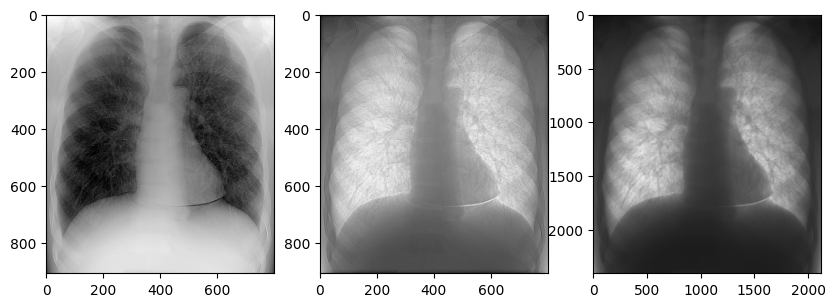

In [63]:
recovered, losses = optimize(conventional_processed, lr=0.01, n_steps=500)

print("Recovered weights:", recovered.w_lookup_table, recovered.w_multiscale_processing)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(conventional_processed, cmap='gray')
ax[1].imshow(recovered.image, cmap='gray')
ax[2].imshow(conventional, cmap='gray')

In [37]:
from src.processings import MultiscaleProcessingWeights, LookupTableWeights, ModelWeights

dtypes: float32 float32

Before update:
Image range: [1.00e+00, 1.00e+00]
Weights: [0.         0.25       0.75       1.         0.         0.1
 0.9        1.         1.         0.33333334 0.33333334 0.33333334]
MSE in loss_fn: Traced<ShapedArray(float32[])>with<JVPTrace> with
  primal = Array(21663.645, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x3449f5560>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace>, Traced<ShapedArray(float32[]):JaxprTrace>), out_tracer_refs=[<weakref at 0x345299df0; to 'JaxprTracer' at 0x345299d50>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = add a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), '

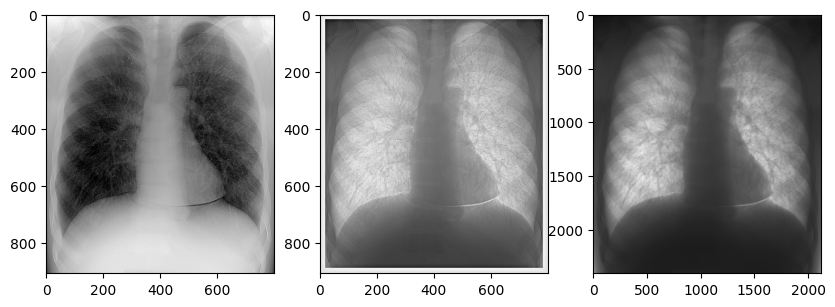

In [34]:
(recovered_image, recovered_weights), losses = optimize(conventional_processed, lr=0.01, n_steps=500)

print("Recovered weights:", recovered_weights)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(conventional_processed, cmap='gray')
ax[1].imshow(recovered_image, cmap='gray')
ax[2].imshow(conventional, cmap='gray')

(array([1311.,  252.,  265.,  304.,  312.,  413.,  441.,  514.,  570.,
         620.,  691.,  760.,  771.,  849.,  948.,  985., 1108., 1223.,
        1223., 1381., 1431., 1449., 1532., 1626., 1715., 1717., 1827.,
        1883., 2063., 2100., 2165., 2194., 2295., 2367., 2351., 2421.,
        2577., 2605., 2632., 2730., 2779., 2879., 3031., 2988., 3090.,
        3053., 3202., 3047., 3176., 3203., 3061., 3170., 3138., 3069.,
        3030., 3188., 3146., 3081., 3027., 3008., 2947., 3033., 2911.,
        2920., 2950., 2831., 2818., 2752., 2899., 2876., 2820., 2968.,
        2830., 2750., 2768., 2771., 2801., 2746., 2764., 2767., 2720.,
        2745., 2727., 2807., 2767., 2599., 2837., 2868., 2855., 2836.,
        2949., 2873., 2856., 2912., 2925., 2887., 2880., 2873., 2922.,
        2855., 2843., 2901., 2863., 2821., 2715., 2885., 2859., 2798.,
        2811., 2869., 2706., 2789., 2894., 2897., 2953., 2853., 2864.,
        2847., 2981., 3079., 3034., 3111., 3209., 3140., 3136., 3171.,
      

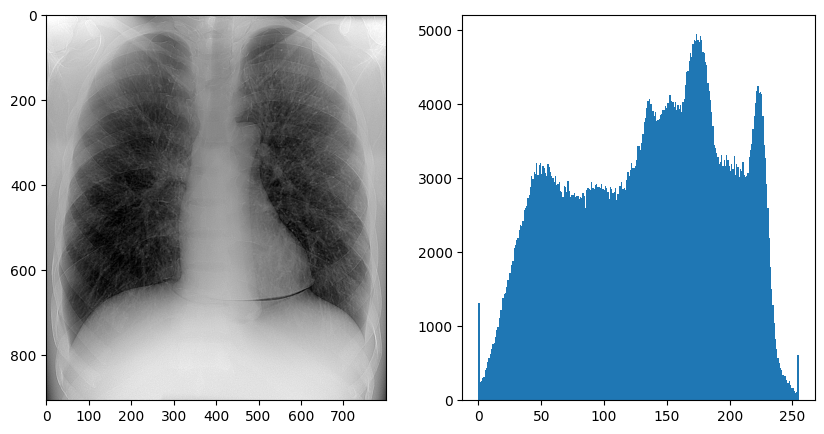

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(conventional_processed, cmap='gray')
ax[1].hist(conventional_processed.ravel(), bins=256)

In [ ]:
conventional.min(), conventional.max()

<Figure size 640x480 with 0 Axes>

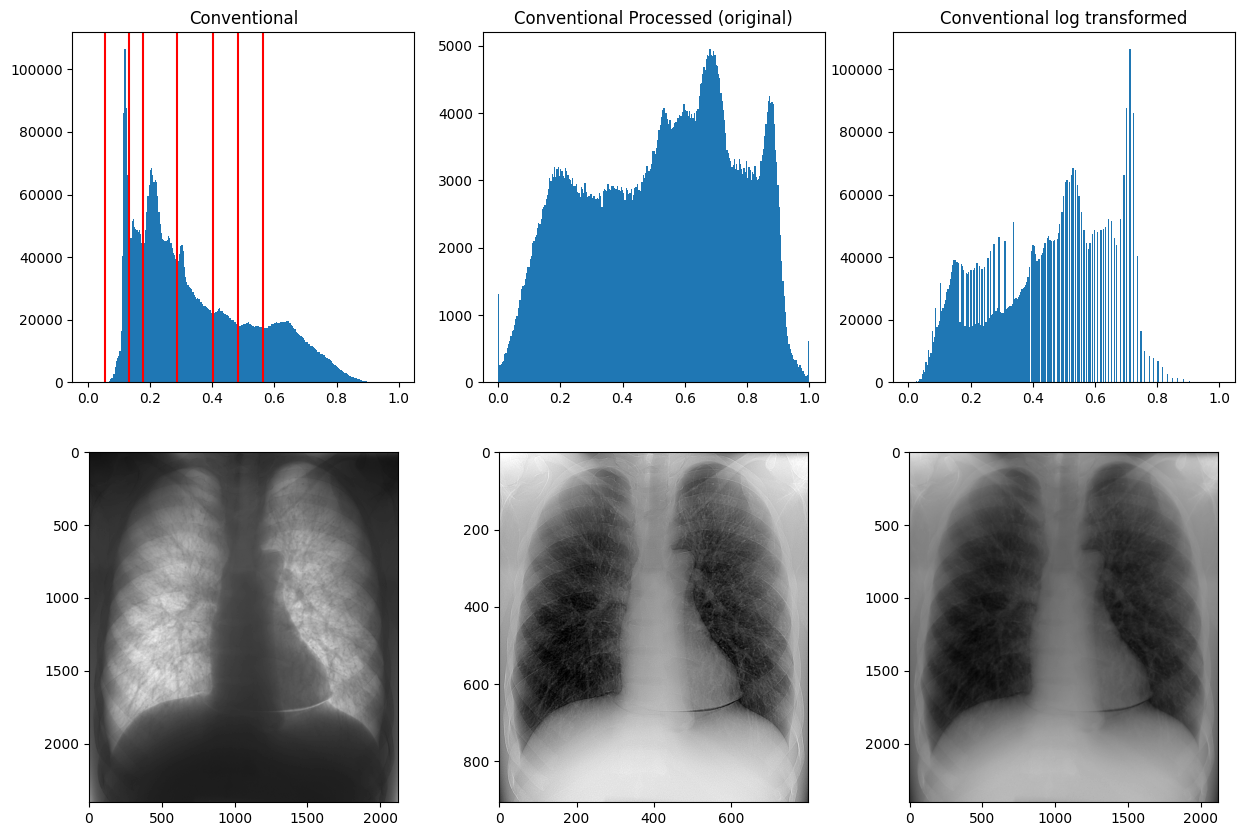

In [62]:
# logt = -np.log(conventional / conventional.max())
# logt[logt == np.inf] = 0
# factor = 0.3

conventional = conventional / conventional.max()
conventional_processed = conventional_processed / conventional_processed.max()


def equalize(image, bits=16):
    bit_dtypes = {8: np.uint8, 16: np.uint16, 32: np.uint32, 64: np.uint64}
    dtype = bit_dtypes.get(bits, np.uint16)

    rng = 2 ** bits - 1
    return cv2.equalizeHist(np.array(image * rng, dtype=dtype)) / rng


zero_eps = 1e-16
logt = equalize(conventional, 8)
logt = conventional / conventional.max()
logt[logt < zero_eps] = zero_eps
logt = -np.log(logt)


logt_norm = logt.copy()
logt_norm = np.clip(logt_norm, 0, 3)

logt_norm = logt_norm / logt_norm.max()

plt.figure()
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax0 = ax[0].flatten()


from scipy.signal import argrelmin

hist, bins = np.histogram(conventional.ravel(), bins=256)
minima = argrelmin(hist, order=5)[0]
minima_positions = bins[minima]


ax0[0].hist(conventional.ravel(), bins=256)
ax0[0].set_title('Conventional')

# plot peaks
for peak in minima_positions:
    ax0[0].axvline(peak, color='r')


ax0[1].hist(conventional_processed.ravel(), bins=256)
ax0[1].set_title('Conventional Processed (original)')
ax0[2].hist(logt_norm.ravel(), bins=256)
ax0[2].set_title('Conventional log transformed')

# plt.figure()
# fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax1 = ax[1].flatten()
ax1[0].imshow(conventional, cmap='gray')
ax1[1].imshow(conventional_processed, cmap='gray')
ax1[2].imshow(logt_norm, cmap='gray')



In [106]:
print(f'{1e-12:.10f}')


0.0000000000


(array([1.70000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

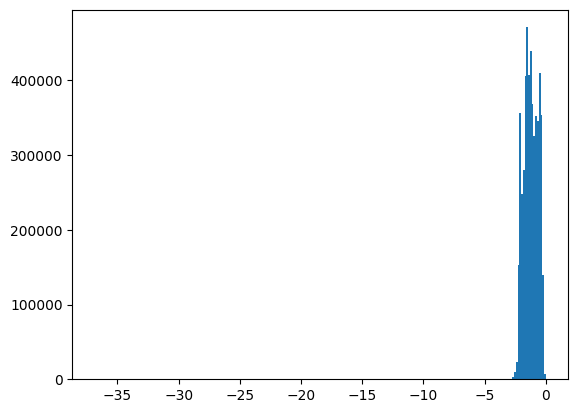

In [122]:
plt.hist(np.log(np.clip(conventional.ravel(), 1e-16, 1.0)), bins=256)

np.float64(1.0)

In [123]:
plt.imshow(-np.log(np.clip(conventional, 1e-8, 1.0)), cmap='gray',vmin=np.e, vmax=np.log(1e-8))

Error in callback <function _draw_all_if_interactive at 0x1318d0940> (for post_execute), with arguments args (),kwargs {}:


ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 640x480 with 1 Axes>

(array([1.70000e+01, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00,
        6.00000e+00, 2.00000e+00, 3.00000e+00, 7.00000e+00, 0.00000e+00,
        9.00000e+00, 3.10000e+01, 3.87000e+02, 9.28000e+02, 1.20900e+03,
        1.52100e+03, 2.59100e+03, 4.97900e+03, 6.71100e+03, 7.71500e+03,
        8.24900e+03, 9.89500e+03, 1.64420e+04, 4.04270e+04, 8.60850e+04,
        1.06511e+05, 8.75490e+04, 6.62480e+04, 5.22540e+04, 4.40140e+04,
        4.60670e+04, 5.15030e+04, 5.20370e+04, 4.96130e+04, 4.90010e+04,
        4.85680e+04, 4.79280e+04, 4.87540e+04, 4.74170e+04, 4.45620e+04,
        4.25030e+04, 4.44820e+04, 4.86060e+04, 5.43760e+04, 5.94340e+04,
        6.30290e+04, 6.77200e+04, 6.86030e+04, 6.62610e+04, 6.41120e+04,
        6.45490e+04, 6.39870e+04, 5.94910e+04, 5.44060e+04, 5.06280e+04,
        4.77890e+04, 4.58550e+04, 4.56170e+04, 4.50850e+04, 4.49910e+04,
        4.54880e+04, 4.66330e+04, 4.59690e+04, 4.44

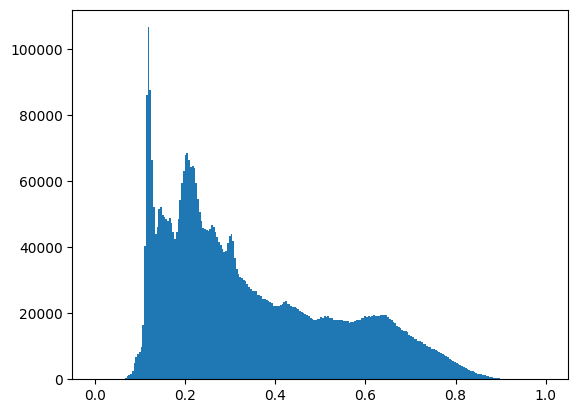

In [92]:
plt.hist(conventional.ravel(), bins=256)

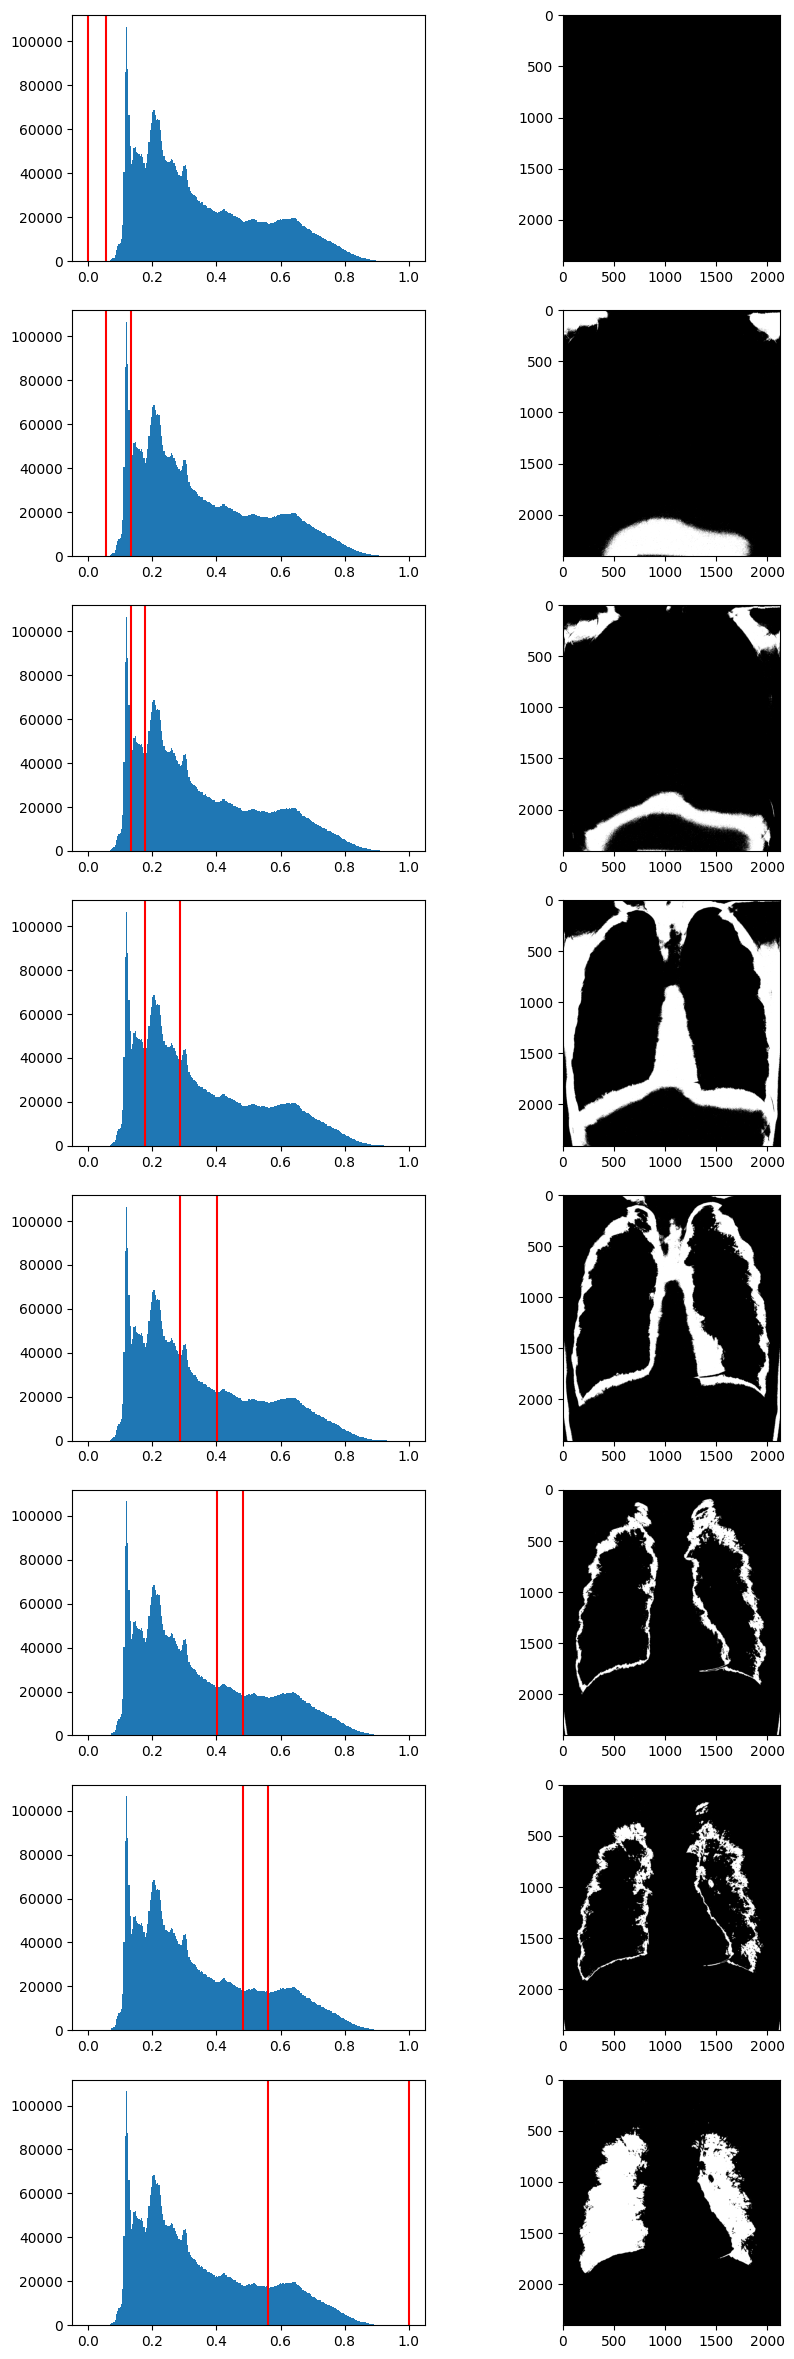

In [85]:
positions = np.concatenate([minima_positions, [1.0]])

minima_count = len(positions)

fig, ax = plt.subplots(minima_count, 2, figsize=(10, 30))

for row in range(minima_count):
    lower_bound = positions[row - 1] if row > 0 else 0
    upper_bound = positions[row]

    base = conventional.copy()
    base[(base < lower_bound) | (base > upper_bound)] = 0
    base[(base >= lower_bound) & (base <= upper_bound)] = 1

    ax[row, 0].hist(conventional.ravel(), bins=256)
    ax[row, 0].axvline(upper_bound, color='r')
    ax[row, 0].axvline(lower_bound, color='r')

    ax[row, 1].imshow(base, cmap='gray')


In [ ]:
from scipy.signal import find_peaks

hist, bins = np.histogram(conventional.ravel(), bins=256)
peaks = find_peaks(hist)[0]
peak_positions = bins[peaks]

array([0.01171875, 0.03125   , 0.0390625 , 0.05078125, 0.1171875 ,
       0.14453125, 0.1640625 , 0.203125  , 0.21484375, 0.2578125 ,
       0.30078125, 0.3515625 , 0.36328125, 0.375     , 0.3984375 ,
       0.421875  , 0.5       , 0.5078125 , 0.515625  , 0.53125   ,
       0.546875  , 0.5546875 , 0.578125  , 0.59765625, 0.60546875,
       0.6171875 , 0.625     , 0.63671875, 0.90234375, 0.91796875,
       0.9453125 , 0.9609375 ])

In [ ]:
k
-np.log(1.0)

In [ ]:
iplt.imshow(-np.log(conventional), cmap='gray')

In [ ]:
(recovered_image, recovered_weights), losses = optimize(conventional_processed, lr=0.01, n_steps=500)

print("Recovered weights:", recovered_weights)

In [ ]:
(recovered_image, recovered_weights), losses = optimize(conventional_processed, lr=0.01, n_steps=500)

print("Recovered weights:", recovered_weights)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(conventional_processed, cmap='gray')
ax[1].imshow(recovered_image, cmap='gray')
ax[2].imshow(conventional, cmap='gray')

In [ ]:
pre = recovered_image - recovered_image.min()



plt.hist(pre.flatten(), bins=256) 
plt.imshow(pre, cmap='gray')

In [ ]:

# plt.matshow(conventional - (pre * 255), cmap='gray')
# plt.imshow(conventional - (pre * 255), cmap='gray')

conventional_og = cv2.imread('data/conventional_transmissionmap.tif', cv2.IMREAD_UNCHANGED)
conventional_og = cv2.resize(conventional_og, conventional_processed.shape[::-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist((conventional_og).flatten())
ax[1].hist((pre * 255).flatten())
# plt.imshow(conventional_og - (pre * 255)), conventional_og.shape

In [ ]:
plt.imshow(cv2.equalizeHist(np.array(pre * 255, dtype=np.uint8)))

In [ ]:
ax = plt.matshow(pre)
fig.colorbar(ax)

In [ ]:
# normalize recovered image
recovered_image_norm = recovered_image / recovered_image.max()
recovered_image_norm = recovered_image_norm - recovered_image_norm.mean()
recovered_image_norm = recovered_image_norm / recovered_image_norm.std()

# plt.hist(recovered_image_norm.flatten(), bins=256)
plt.imshow(recovered_image_norm, cmap='gray')

In [ ]:
cv2.imwrite('data/raw_recovered.tif', np.array(recovered_image * (2 ** 16 - 1), dtype=np.uint16))

In [ ]:
original_image = raw
if original_image.max() > 1:
    original_image = original_image / original_image.max()

true_weights = jnp.array([0.3, 0.5, 0.2])
filter_sizes = (3, 5, 7) 
processed = forward(original_image, true_weights, filter_sizes)

# Recover original
(recovered_image, recovered_weights), losses = optimize(processed, lr=1, n_steps=500)

# Print results
print("True weights:", true_weights)
print("Recovered weights:", recovered_weights)

In [72]:
def compare_images(original, transformed, recovered, true_weights=None, recovered_weights=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'Original\n[{original.min():.3f}, {original.max():.3f}]')
    
    axes[1].imshow(transformed, cmap='gray')
    axes[1].set_title(f'Transformed\n[{transformed.min():.3f}, {transformed.max():.3f}]')
    if true_weights is not None:
        axes[1].set_xlabel(f'Weights: {true_weights.round(3)}')
    
    axes[2].imshow(recovered, cmap='gray')
    axes[2].set_title(f'Recovered\n[{recovered.min():.3f}, {recovered.max():.3f}]')
    if recovered_weights is not None:
        axes[2].set_xlabel(f'Weights: {recovered_weights.round(3)}')
    
    plt.tight_layout()
    plt.show()
    
    # Print difference statistics
    print(f"Original vs Transformed MSE: {((original - transformed)**2).mean():.3e}")
    print(f"Original vs Recovered MSE: {((original - recovered)**2).mean():.3e}")
    print(f"Transformed vs Recovered MSE: {((transformed - recovered)**2).mean():.3e}")


In [ ]:
cv2.imwrite('data/raw_recovered.tif', np.array(recovered_image * 255, dtype=np.uint8))

In [ ]:
cv2.imwrite('data/raw_transformed.tif', np.array(processed * 255, dtype=np.uint8))

In [ ]:
plt.imshow(original_image, cmap='gray')

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col')
axes = ax.flatten()

axes[0].imshow(recovered_image, vmin=recovered_image.min(), vmax=recovered_image.max(), cmap='gray')
recovered_transform = forward(recovered_image, recovered_weights, filter_sizes)
axes[1].imshow(recovered_transform, cmap='gray')

axes[2].imshow(original_image, vmax=0.2, cmap='gray')
axes[3].imshow(processed, vmax=0.2, cmap='gray')

In [ ]:
ax = plt.matshow(recovered_image)
fig.colorbar(ax)

In [ ]:
(recovered_image * 255).min(), (recovered_image * 255).max()

In [ ]:
(1e-5+9.999e-1) * 10

In [ ]:
plt.hist(recovered_image.flatten(), bins=256)

In [ ]:
cv2.imwrite('data/raw_recovered_ones_transformed.tif', np.array(recovered_transform * 65535, dtype=np.uint16))
cv2.imwrite('data/raw_recovered_ones.tif', np.array(recovered_image * 65535, dtype=np.uint16))

In [ ]:
plt.hist(raw.flatten(), bins=256)

In [ ]:
transformed = forward(original_image, true_weights, filter_sizes)
recovered, recovered_weights = optimize(transformed, filter_sizes)[0]

compare_images(original_image, transformed, recovered, true_weights, recovered_weights)

In [ ]:
plt.imshow(transformed, cmap='gray')